## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = "".join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [4]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2021-12-12 18:18:51--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.1’

onegin.txt.1        100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2021-12-12 18:18:51 (8.02 MB/s) - ‘onegin.txt.1’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.
text = "".join(text).lower()
text

'\ni\n\n«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдумать не мог.\nего пример другим наука;\nно, боже мой, какая скука\nс больным сидеть и день и ночь,\nне отходя ни шагу прочь!\nкакое низкое коварство\nполуживого забавлять,\nему подушки поправлять,\nпечально подносить лекарство,\nвздыхать и думать про себя:\nкогда же черт возьмет тебя!»\n\n\n\nii\n\nтак думал молодой повеса,\nлетя в пыли на почтовых,\nвсевышней волею зевеса\nнаследник всех своих родных. —\nдрузья людмилы и руслана!\nс героем моего романа\nбез предисловий, сей же час\nпозвольте познакомить вас:\nонегин, добрый мой приятель,\nродился на брегах невы,\nгде, может быть, родились вы\nили блистали, мой читатель;\nтам некогда гулял и я:\nно вреден север для меня\n\n\niii\n\nслужив отлично-благородно,\nдолгами жил его отец,\nдавал три бала ежегодно\nи промотался наконец.\nсудьба евгения хранила:\nсперва madame за ним ходила,\nпотом monsieur ее сменил;\nребенок был резов, но 

Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(text))
num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
token_to_idx = dict()
for i in range(len(tokens)):
    token_to_idx[tokens[i]] = i  
# Your great code here
# dict <char>:<index>
# Your great code here
idx_to_token = dict()
for i in range(len(tokens)):
    idx_to_token[i] = tokens[i]

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [9]:
class CharRNNLoopVanillaHot(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.hidden_size = rnn_num_units
        self.num_tokens = num_tokens
        self.rnn = nn.RNN(num_tokens, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden):
        assert isinstance(x.data, torch.LongTensor)
        x = torch.nn.functional.one_hot(x, self.num_tokens).float()
        h_seq, _ = self.rnn(x)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden

    def initial_state(self, batch_size = 1):
        return torch.zeros((1, batch_size, self.hidden_size))

**Remark:** то save function semantics, use fake hidden.

In [10]:
char_rnn_vanilla = CharRNNLoopVanillaHot()
opt = torch.optim.Adam(char_rnn_vanilla.parameters(), lr=0.001)
char_rnn_vanilla.train()

CharRNNLoopVanillaHot(
  (rnn): RNN(83, 64, batch_first=True)
  (hid_to_logits): Linear(in_features=64, out_features=83, bias=True)
)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [11]:
def convert(batch):
    return torch.LongTensor([[token_to_idx[ch] for ch in batch]])

In [12]:
def make_best_train(model, num_iterations, chunk_sz, criterion, opt, text, st):
    history= []
    hidden = None
    for idx in tqdm(range(0, len(text) - chunk_sz - 1, st)):
        opt.zero_grad()

        chuck = text[idx: idx + chunk_sz + 1]

        inp, target = convert(chuck[:-1]), convert(chuck[1:])
        logp_seq_hidden, _ = model(inp, hidden)
        loss = criterion(logp_seq_hidden.permute((0 ,2 ,1)) ,target)

        history.append(loss)
        loss.backward()
        opt.step()
    return history

In [13]:
hist = make_best_train(char_rnn_vanilla, 1000, 128, nn.NLLLoss(), opt,  text, 24)

  0%|          | 0/5907 [00:00<?, ?it/s]

In [20]:
def make_plot(hist):
    plt.figure(figsize= (16, 9))
    plt.xlabel("#epochs", fontsize = 20)
    plt.ylabel("loss", fontsize = 20)
    plt.plot(np.arange(len(hist)) + 1, hist)
    plt.title("loss to epochs", fontsize = 20)
    plt.show()
    print(f'Final loss - {hist[-1]}')

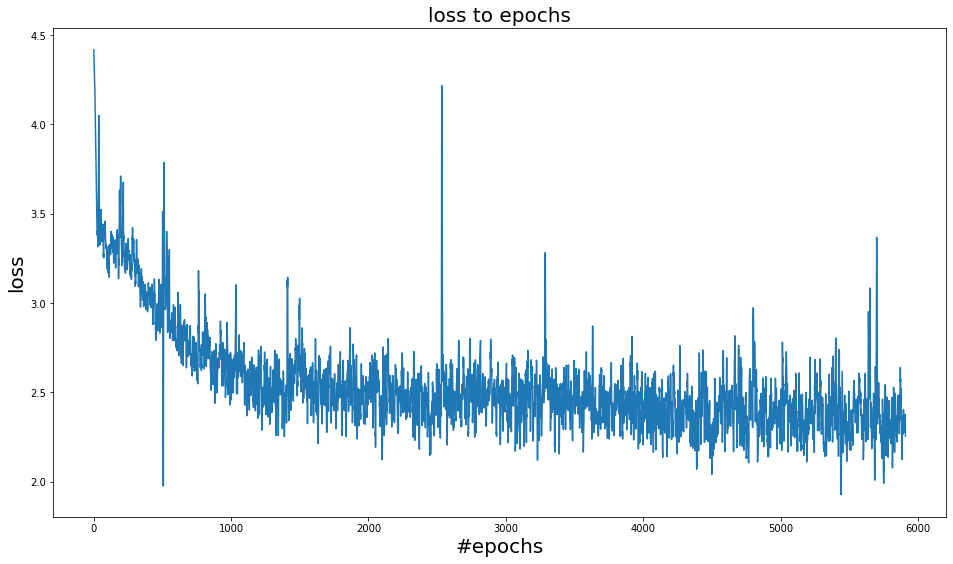

Final loss - 2.254938840866089


In [21]:
make_plot(hist)

In [22]:
MAX_LENGTH  = 128
def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state()
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence, hid_state)
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence, hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0][-1]

        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)

        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [23]:
# An example of generated text.
print(generate_sample(char_rnn_vanilla, seed_phrase='мой дядя', max_length=500, temperature=0.2))

мой дядя встолиней милиний сердце строгоной строва старина строго всторала сердце строго встилина стрований страней с дрогониней стровой сердце строва,
и та сторова строгоним сердце стровастой даланий странена,
и тать оне не стровас в страней замити, с вестаний с разаланий сердце строго ластали и стораних странений с разно та стораний сердце строваней строго строгон оно встой не строгони встой он она всталиний с разалиний с вать он оне и в дерана




















































### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [24]:
class CharRNNLoopLSTMHot(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.hidden_size = rnn_num_units
        self.num_tokens = num_tokens
        self.rnn = nn.LSTM(num_tokens, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden):
        assert isinstance(x.data, torch.LongTensor)
        x = torch.nn.functional.one_hot(x, self.num_tokens).float()
        h_seq, _ = self.rnn(x)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden

    def initial_state(self, batch_size = 1):
        return torch.zeros((1, batch_size, self.hidden_size))

In [25]:
char_rnn_lstm = CharRNNLoopLSTMHot()
opt = torch.optim.Adam(char_rnn_lstm.parameters(), lr=0.001)
char_rnn_lstm.train()

CharRNNLoopLSTMHot(
  (rnn): LSTM(83, 64, batch_first=True)
  (hid_to_logits): Linear(in_features=64, out_features=83, bias=True)
)

In [26]:
hist = make_best_train(char_rnn_lstm, 1000, 128, nn.NLLLoss(), opt,  text, 24)

  0%|          | 0/5907 [00:00<?, ?it/s]

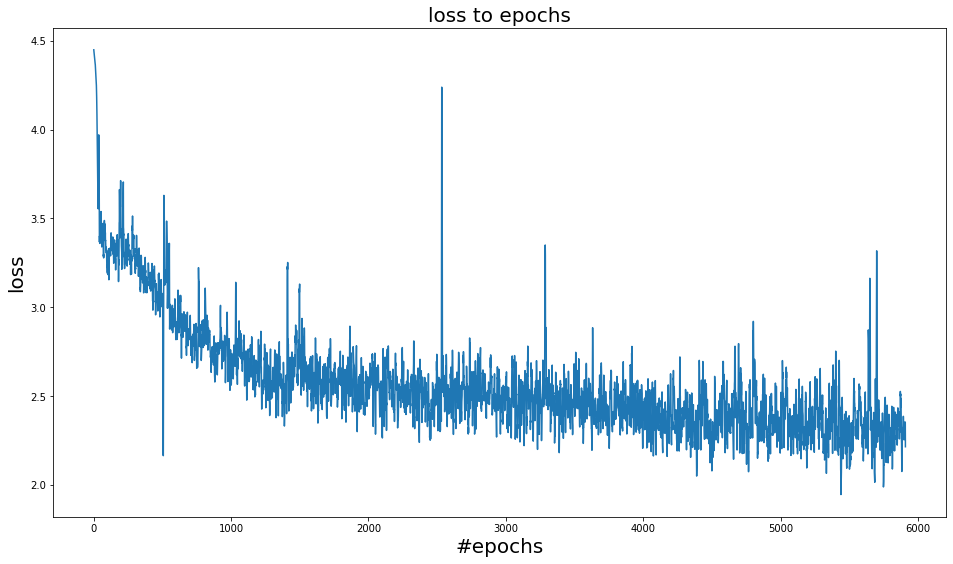

Final loss - 2.213904857635498


In [29]:
make_plot(hist)

**Conclusion:** The final loss did't decrease. But let consider the generation of the text

In [30]:
print(generate_sample(char_rnn_lstm, seed_phrase='мой дядя', max_length=500, temperature=0.2))

мой дядя,
и то сторини сторонной стразной
как даль он в сердитья на быль
не доль он сердиль онеста
на сторить с серда страна
на всторить не сторой стране



xlii

и то дало с не страна
проду на сторить немой
и с не стори на странной
и прода в сердить серани
и та сто не на серана
и тать не в сторини страсте
и то сторой он сорани,
и продо на страста страсто
и за страста на в сладит,
и то не слого в серени,
продить он серной серани



xliii

не сторит он в серной страненья,
как он сторой в страдной


**Conclusion:** It looks better than simple rnn, we can see poem structure here!

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [31]:
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
seeds = ['мой дядя', 'вздыхать и думать', 'долгами жил его отец', '\nсудьба евгения', 'ребенок был резов']
def make_temperature_test(model, temperatures, seeds):
    for temp, seed in zip(temperatures, seeds):
         print(f"seed = {seed}, temperature = {temp}")
         print(generate_sample(model, seed_phrase=seed, max_length=500, temperature=temp))
         print("--------------")
         print("--------------")

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [32]:
torch.save(char_rnn_lstm, "./lstm_model")

In [33]:
model_load = torch.load("./lstm_model")

In [34]:
make_temperature_test(model_load, temperatures, seeds)

seed = мой дядя, temperature = 0.1
мой дядя,
и порадной стороной страста
и то страстали страста,
и продить не страстали,
и породной страста,
и порастали страста,
и продиль он серда страни



xlii

и не сторини серный страста
и продили страсталиной
и с серда не страста
и та страстали в серенный страни



xliii

и то страстали страни,
и продили в сторить оне



xliii

и продиль оне не страста
на сторить и страстали
и та не сторой не страной
и то сторани страста,
и с серенный страстали
и та не страстали страни



xlii

и то не сторо
--------------
--------------
seed = вздыхать и думать, temperature = 0.2
вздыхать и думать
на сторой не странить страдить
и продали сераней,
и страстали сторани,
и порастало в сторенный страдный
он серда не не стразной
и серой он он строго



xlii

и с серенья страстой стренный страни



xlii

и серенный сторный сторани



xlii

и то проду не морой на разной
и проденный судалиной
простали не сторь она



xlii

и придам он сердаль она



xlii

оне страстали в 

 **Conclusion:** By my own opinion, best results are for temperatures 0.5 and 1.0

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)